In [1]:
%pylab inline


import numpy as np
import torch
import os
import sys
import pickle
#Importing the package
root_dir = os.getcwd()
sys.path.append(os.path.abspath(root_dir+'/WCRG'))
sys.path.append(os.path.abspath(root_dir+'/WCRG/WCRG'))
sys.path.append(os.path.abspath(root_dir+'/WCRG/Wavelet_Packets'))
sys.path.append(os.path.abspath(root_dir+'/WCRG/WCRG/Models'))
#Wavelets
from Wavelet_Packets import *
#Ansatz
from WCRG import *

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
#device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Synthese  WL maps from WCRG model  (pixel values standardized, aka TRANS)

In [3]:
#data
data = np.load(root_dir+"/DGAN/cosmo_primary_128_5k_train_trans.npy")

In [4]:
#to pytorch
Data = torch.tensor(data).to(device).to(torch.float32)

In [5]:
print(Data.shape, Data.mean(),Data.std())

torch.Size([5000, 128, 128]) tensor(0.0061, device='cuda:0') tensor(0.9984, device='cuda:0')


In [6]:
#Computing the number of scales
J=int(np.log2(Data.shape[-1])) #Images of size 2**J
print('J = '+str(J))

J = 7


In [7]:
#Wavelet
m=4
W=Db_wavelets(m,device=device,mode='Periodic') #Debauchies 4

In [8]:
KEY="map_128"
dir_synth = './SynthsTrans/'
dir_mod = './ModelsTrans/'

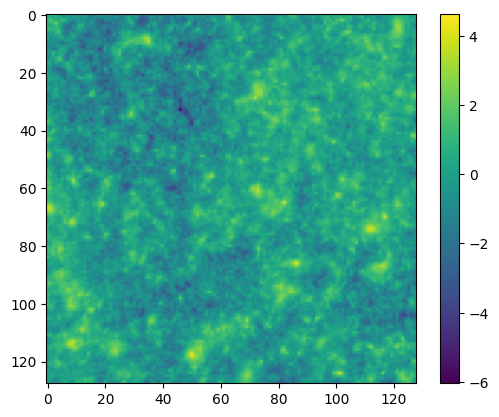

tensor(-0.1342, device='cuda:0')


In [9]:
imshow(Data[0].cpu());colorbar();
show()
print(Data[0].mean())

In [10]:
def my_Mala(ansatz_union,x_0,x_condi,n_steps,step_size,window_min,window_max, 
           n_print_freq=10) :
    """Conditionnal Windowed MALA Dynamic
    
    Parameters:
    ansatz_union (Condi_ansatz object) : The ansatz giving the gradient for MALA Dynamic
    x_0 (tensor) : (n_batch,n_chanels,N,N) Seed from which we start MALA dynamic
    x_condi (tensor) : (n_batch,n_condi,N',N') each batch element i is conditionned from x_condi[i]
    n_steps (int) : number of steps 
    step_size (float) : step size  
    window_min (float) : keep the update only if the reconstruction has no pixel < window_min
    window_max (float) : keep the update only if the reconstruction has no pixel > window_max

    
    
    Returns:
        x (tensor) :Result of MALA Dynamic (n_batch,n_chanels,N,N)
    
    """
    
    theta = ansatz_union.theta().detach() # (n_potentials,)
    
    x=torch.clone(x_0)
    n_batch = len(x)
    for _ in range(n_steps):
      # x (*,n_1,n_2,n_3)
      """Won't work if  has another shape"""
      # x_condi tuple of (*,n_1,..)
      #COMPUTE GRADIENT IN X_t
      gradient = ansatz_union.gradient(x,x_condi,theta) # (*,1,n_1,n_2,n_3)
      gradient = gradient[:,0] # (*,n_1,n_2,n_3)
      #COMPUTE NOISE
      noise = np.sqrt(2*step_size)*torch.randn_like(x) # (*,n_1,n_2,n_3)

      x_new = x - step_size * gradient + noise # (*,n_1,n_2,n_3)


      #METROPOLIS Rule
      gradient_new = ansatz_union.gradient(x_new,x_condi,theta) # (*,1,n_1,n_2,n_3)
      gradient_new = gradient_new[:,0]# (*,n_1,n_2,n_3)
    
      log_qx,log_qx_new  = log_Q(x_new.reshape((x.shape[0],-1)), x.reshape((x.shape[0],-1)),gradient.reshape((x.shape[0],-1)),gradient_new.reshape((x.shape[0],-1)), step_size) #(n_batch)
      
      
      log_pix = - ansatz_union.potential_batch(x,x_condi,theta).sum(1) #(*,)
      log_pix_new = - ansatz_union.potential_batch(x_new,x_condi,theta).sum(1) #(*,)
    
      log_ratio = log_pix_new-log_pix+log_qx - log_qx_new
      
      
    
      
      #Windowed Langevin, do not update outside of the window
      x_rec = ansatz_union.reconstruct(x_condi[0],x_new)
      #Both conditions
      ind_max =  torch.where(torch.max(x_rec.reshape((x_rec.shape[0],-1)),1)[0]>window_max)[0]
      ind_min =  torch.where(torch.max(-x_rec.reshape((x_rec.shape[0],-1)),1)[0]>-window_min)[0]
      RANDOM = torch.rand(log_ratio.shape,device = log_ratio.device )
      ind_mala = torch.where((RANDOM-torch.exp(log_ratio))>0)[0]
      if _%n_print_freq ==0:
        print('Acceptance_rate ='+str(1-len(ind_mala)/n_batch))
      x_new[ind_min] = x[ind_min]
      x_new[ind_max] = x[ind_max]
      x_new[ind_mala] = x[ind_mala]
      x = x_new
      
       
    
    return(x)



def my_LANGEVINMALA(ansatz_union,
             x_0,
             window_min,
             window_max,
             n_steps,
             step_size,
             n_batch,
             n_repeat, Show_langevin = None,x_compare=None, 
                   n_print_freq=10):
                 
    """Conditionnal Windowed MALA Dynamic
    
    Parameters:
    ansatz_union (Condi_ansatz object) : The ansatz giving the gradient for MALA Dynamic
    x_0 (tensor) : (n_batch,L,L), dynamic is conditionned by x_0 low frequencies
    window_min (float) : keep the update only if the reconstruction has no pixel < window_min
    window_max (float) : keep the update only if the reconstruction has no pixel > window_max
    n_steps (int) : number of steps 
    step_size (float) : step size  
    n_batch (int) : MALA is applied to batches of size of size n_batch ( from x_0[n_batch*k:n_batch*(k+1)] low frequencies )
    n_repeat (int) : number of batches (k in range(n_repeat) )
    Show_langevin (func) : if specified, a plot function Show_langevin(x_0,x_reco) is runed
    x_compare (tensor) : if specified, a plot function Show_langevin(x_compare,x_reco) is runed
    

    
    
    Returns:
        x_reco (tensor) :Result of MALA Dynamic reconstructed using low frequencies from which it has been sampled (n_batch*n_repeat,L,L)
    
    """

    x_reco=[]
    for k in range(n_repeat):  
      print(f"repeat: {k+1}/{n_repeat}")
      x = x_0[n_batch*k:n_batch*(k+1)].cuda()
      x_condi,x_hf = ansatz_union.decompose(x)
      x_zeros = torch.zeros(x_hf.shape,device=x_hf.device)
      #x_zeros = torch.randn_like(x_hf)*(window_max-window_min)/2
      x_langevin = my_Mala(ansatz_union,x_zeros,x_condi,n_steps,step_size,window_min,window_max,
                           n_print_freq=n_print_freq)
      x_reco.append(ansatz_union.reconstruct(torch.repeat_interleave(x_condi[0], 1, dim=0),x_langevin).cpu())

    #Concatenate the sampled images
    x_reco = torch.concat(x_reco)
    if x_compare is None :
      x_compare = x_0
    #Compare to x_0 where we cut higher frequencies, if some where still there! 
    x_condi,x_hf = ansatz_union.decompose(x_compare)
    x = ansatz_union.reconstruct(x_condi[0],x_hf)

    #show
    if Show_langevin is not None:
        Show_langevin(x,x_reco)
    return(x_reco)

In [11]:
def my_Show_langevin(x,x_reco,log=False):
  """Compares original DATA and synthesis data X_fake

  Parameters:
  DATA (tensor): (n_batch,L,L)
  X_fake (tensor): (n_batch,L,L)
  log (Bool): if True log scale

  """
  Compare_Spectrum(x,x_reco,log=log)

  plt.hist(x_reco.detach().cpu().reshape((-1,)),label='Langevin',density=True, cumulative=True,bins=50)
  plt.hist(x.detach().cpu().reshape((-1,)),alpha=0.5,label='True',density=True, cumulative=True,bins=50)
  plt.legend()
  plt.show()

  plt.hist(x_reco.detach().cpu().reshape((-1,)),label='Langevin',density=True, cumulative=False,bins=50)
  plt.hist(x.detach().cpu().reshape((-1,)),alpha=0.5,label='True',density=True, cumulative=False,bins=50)
  if log == True:
      plt.yscale('log')
  plt.legend()
  plt.show()

  print('mean_true = '+str(x.detach().cpu().reshape((-1,)).mean()))
  print('std_true = '+str(x.detach().cpu().reshape((-1,)).reshape((-1,)).std()))
  print('mean_langevin = '+str((x_reco).detach().cpu().reshape((-1,)).mean()))
  print('std_langevin = '+str((x_reco).detach().cpu().reshape((-1,)).std()))

  #Sample example
  plt.imshow(x[0].detach().cpu())
  plt.title('True')
  plt.show()
  plt.imshow(x_reco[0].detach().cpu())
  plt.title('Langevin')
  plt.show()
  

  #Covariances (Stationnary)
  cov_x = sfft.fftshift(torch.fft.ifft2(torch.fft.fft2(x).abs()**2).mean(0).detach().cpu().real)
  cov_langevin = sfft.fftshift(torch.fft.ifft2(torch.fft.fft2(x_reco).abs()**2).mean(0).detach().cpu().real)
  plt.imshow(cov_x)
  plt.title('True')
  plt.colorbar()
  plt.show()
  plt.imshow(cov_langevin)
  plt.title('Langevin')
  plt.colorbar()
  plt.show()


# L= 1

In [12]:
#Define Scale, maps of size 1*1 = L*L
L=1
depth = J-int(np.log2(L))
#print(depth)
#Load Real data x_J, for comparison only
phi_s = load_data(W,Data,depth,J,show_hist=False)

In [13]:
#Load The model we will sample from
ansatz = load_ansatz(L,KEY,dir_mod)

In [14]:
#Sampling
window_min,window_max = ansatz.ansatze[0].centers[0],ansatz.ansatze[0].centers[-1]
n_repeat = 1
n_batch = len(phi_s)
n_steps = 500
step_size = 300
x_reco = my_LANGEVINMALA(ansatz,
             torch.zeros_like(phi_s),
             window_min,
             window_max,
             n_steps,
             step_size,
             n_batch,
             n_repeat,
            n_print_freq=n_steps//10)

repeat: 1/1
Acceptance_rate =0.9624


/sps/lsst/users/campagne/anaconda3/envs/pytexture/lib/python3.8/site-packages/torch/_functorch/deprecated.py:80: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacrev instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacrev')
/sps/lsst/users/campagne/anaconda3/envs/pytexture/lib/python3.8/site-packages/torch/_functorch/deprecated.py:58: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.ht

Acceptance_rate =0.9636
Acceptance_rate =0.9714
Acceptance_rate =0.9684
Acceptance_rate =0.9666
Acceptance_rate =0.968
Acceptance_rate =0.9666
Acceptance_rate =0.9656
Acceptance_rate =0.966
Acceptance_rate =0.9648


In [15]:
x_reco.shape, phi_s.shape

(torch.Size([5000, 1, 1]), torch.Size([5000, 1, 1]))

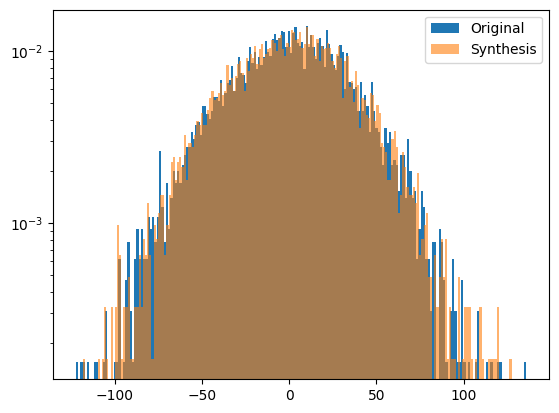

In [16]:
compare_hist(x_reco,phi_s)

In [17]:
#save the generated x_J
save(x_reco,L,KEY,dir_synth)

# L = 2

In [18]:
#Define Scale, maps of size 2^{J-j}*2^{J-j} = L*L
L=2
depth = J-int(np.log2(L))
print('depth = '+str(depth))
#Load Real data x_j, for comparison only
phi_s = load_data(W,Data,depth,J,show_hist=False)

depth = 6


In [19]:
#Load The model we will sample from
ansatz = load_ansatz(L,KEY,dir_mod)

In [20]:
#We generate \bar x_{j+1} conditionaly to previously sampled x_{j+1}
x_reco = load(L//2,KEY,W,dir_synth)

window_min,window_max = ansatz.ansatze[0].centers[0],ansatz.ansatze[0].centers[-1]
n_repeat = 1
n_batch = len(x_reco)
n_steps = 100
step_size = 25
n_repeat = 1
x_reco = my_LANGEVINMALA(ansatz,
             x_reco,
             window_min,
             window_max,
             n_steps,
             step_size,
             n_batch,
             n_repeat,
            n_print_freq=n_steps//10)

torch.Size([5000, 1, 1])
torch.Size([5000, 2, 2])
repeat: 1/1
Acceptance_rate =0.9816
Acceptance_rate =0.9826
Acceptance_rate =0.9804
Acceptance_rate =0.9814
Acceptance_rate =0.9816
Acceptance_rate =0.9796
Acceptance_rate =0.9812
Acceptance_rate =0.984
Acceptance_rate =0.983
Acceptance_rate =0.9828


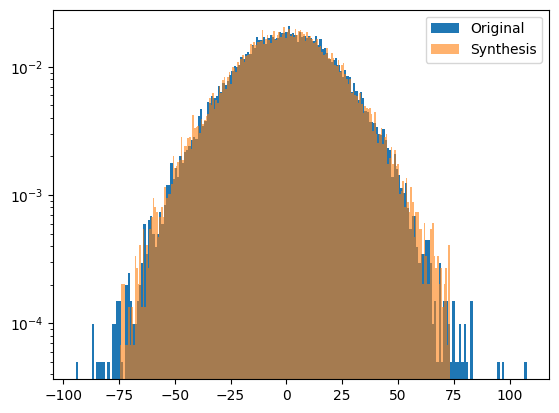

In [21]:
compare_hist(x_reco,phi_s)

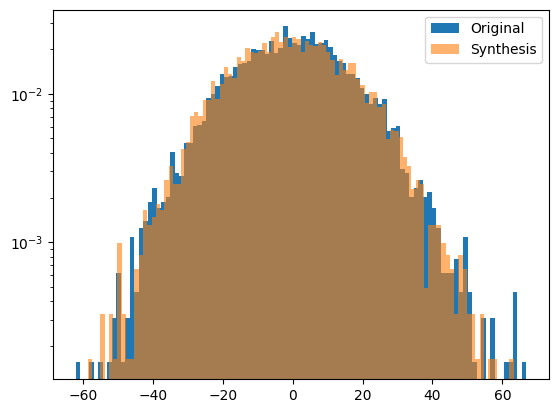

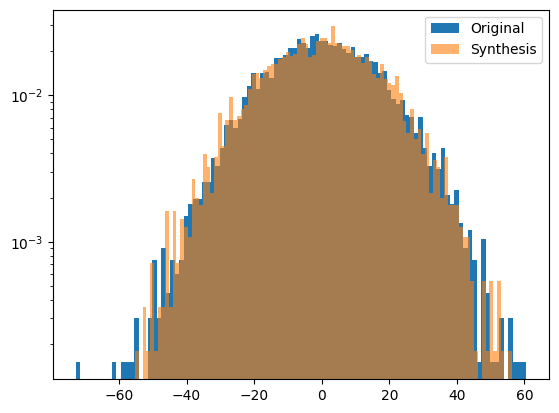

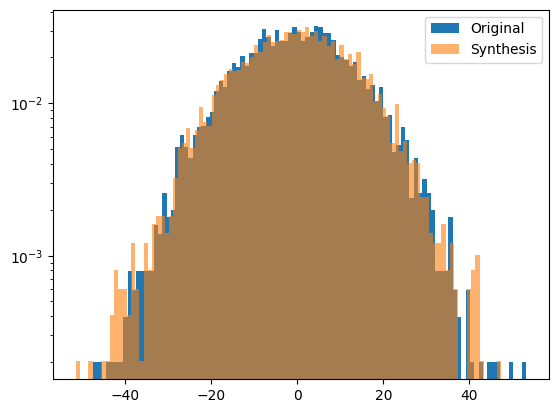

In [22]:
x_high_reco = ansatz.decompose(x_reco.cuda())[1]
x_high = ansatz.decompose(phi_s)[1]
compare_hist(x_high_reco[:,0],x_high[:,0],bins=100)
compare_hist(x_high_reco[:,1],x_high[:,1],bins=100)
compare_hist(x_high_reco[:,2],x_high[:,2],bins=100)

In [23]:
save(x_reco,L,KEY,dir_synth)

# L = 4

In [24]:
#Define Scale, maps of size 2^{J-j}*2^{J-j} = L*L
L=4
depth = J-int(np.log2(L))
print('depth = '+str(depth))
#Load Real data x_j, for comparison only
phi_s = load_data(W,Data,depth,J, show_hist=False)

depth = 5


In [25]:
#Load The model we will sample from
ansatz = load_ansatz(L,KEY,dir_mod)

In [26]:
x_reco = load(L//2,KEY,W,dir_synth)

window_min,window_max = ansatz.ansatze[0].centers[0],ansatz.ansatze[0].centers[-1]
n_repeat = 1
n_batch = len(x_reco)
n_steps = 40
step_size = 10
x_reco = my_LANGEVINMALA(ansatz,
             x_reco,
             window_min,
             window_max,
             n_steps,
             step_size,
             n_batch,
             n_repeat,
            n_print_freq=n_steps//10)

torch.Size([5000, 2, 2])
torch.Size([5000, 4, 4])
repeat: 1/1
Acceptance_rate =0.9054
Acceptance_rate =0.921
Acceptance_rate =0.9266
Acceptance_rate =0.927
Acceptance_rate =0.9256
Acceptance_rate =0.9334
Acceptance_rate =0.9328
Acceptance_rate =0.9299999999999999
Acceptance_rate =0.9346
Acceptance_rate =0.9339999999999999


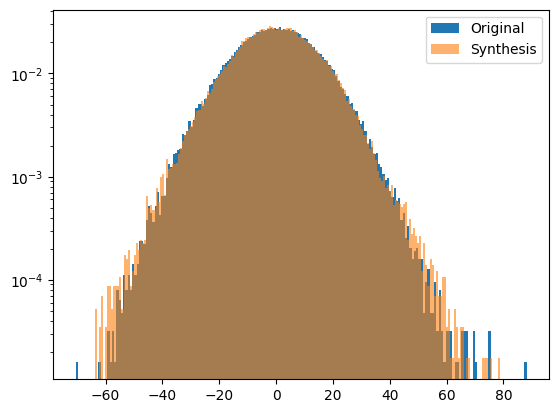

In [27]:
compare_hist(x_reco,phi_s,)

In [28]:
save(x_reco,L,KEY,dir_synth)

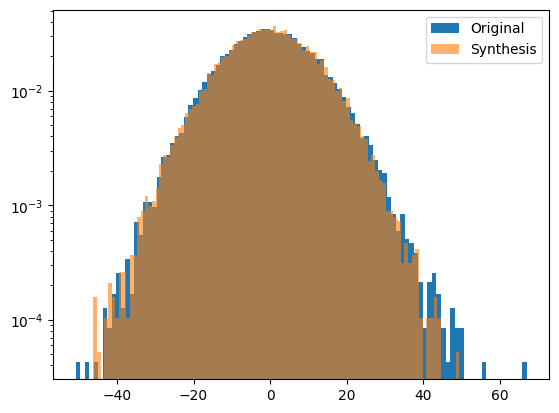

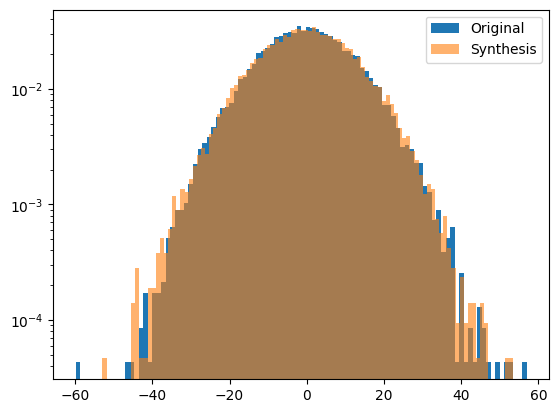

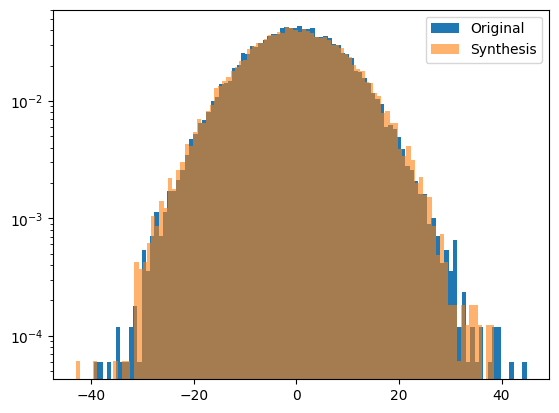

In [29]:
x_high_reco = ansatz.decompose(x_reco.cuda())[1]
x_high = ansatz.decompose(phi_s)[1]
compare_hist(x_high_reco[:,0],x_high[:,0],bins=100)
compare_hist(x_high_reco[:,1],x_high[:,1],bins=100)
compare_hist(x_high_reco[:,2],x_high[:,2],bins=100)

# L = 8

In [30]:
#Define Scale, maps of size 2^{J-j}*2^{J-j} = L*L
L=8
depth = J-int(np.log2(L))
print('depth = '+str(depth))
#Load Real data x_j, for comparison only
phi_s = load_data(W,Data,depth,J,show_hist=False)

depth = 4


In [31]:
#Load The model we will sample from
ansatz = load_ansatz(L,KEY,dir_mod)

In [32]:
#We generate \bar x_{j+1} conditionaly to previously sampled x_{j+1}
x_reco = load(L//2,KEY,W,dir_synth)

window_min,window_max = ansatz.ansatze[0].centers[0],ansatz.ansatze[0].centers[-1]
n_repeat = 1
n_batch = len(x_reco)
n_steps = 100
step_size = 8
x_reco = my_LANGEVINMALA(ansatz,
             x_reco,
             window_min,
             window_max,
             n_steps,
             step_size,
             n_batch,
             n_repeat,
            n_print_freq=n_steps//10)

torch.Size([5000, 4, 4])
torch.Size([5000, 8, 8])
repeat: 1/1
Acceptance_rate =0.29379999999999995
Acceptance_rate =0.6898
Acceptance_rate =0.7585999999999999
Acceptance_rate =0.7684
Acceptance_rate =0.7754
Acceptance_rate =0.7488
Acceptance_rate =0.7698
Acceptance_rate =0.7604
Acceptance_rate =0.7624
Acceptance_rate =0.7672


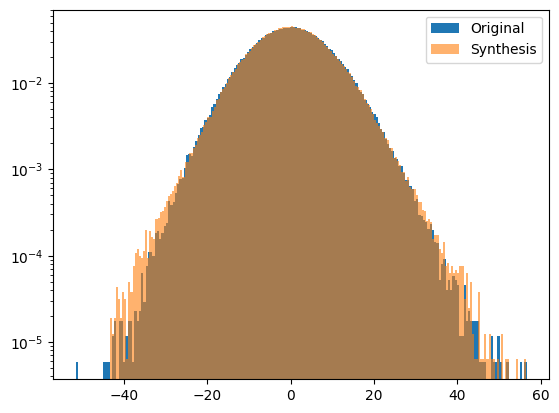

In [33]:
compare_hist(x_reco,phi_s)

In [34]:
save(x_reco,L,KEY,dir_synth)

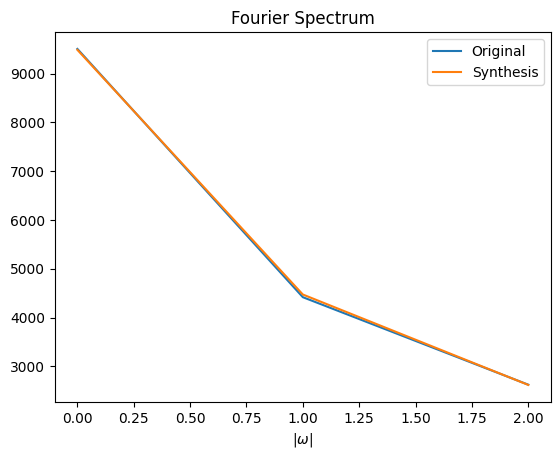

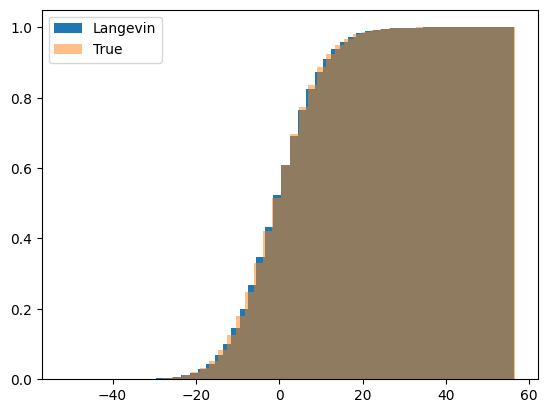

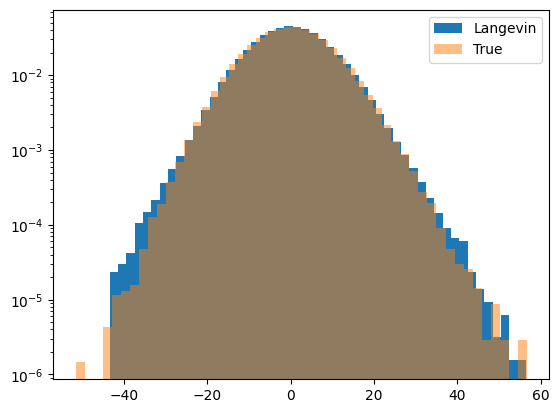

mean_true = tensor(0.0981)
std_true = tensor(9.3475)
mean_langevin = tensor(0.0967)
std_langevin = tensor(9.3565)


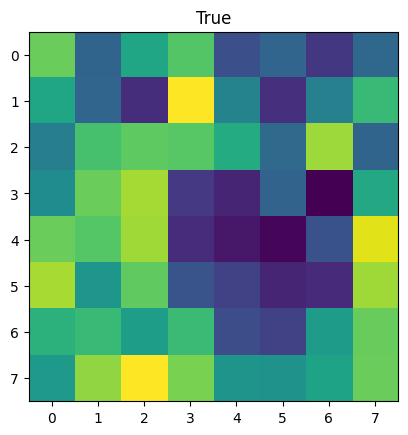

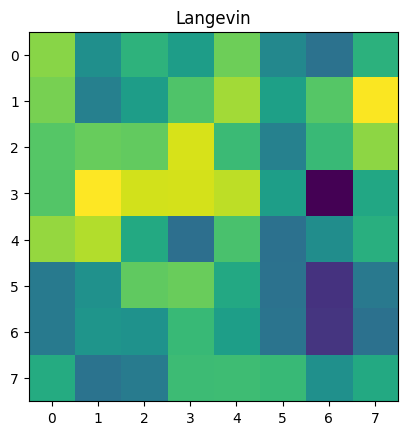

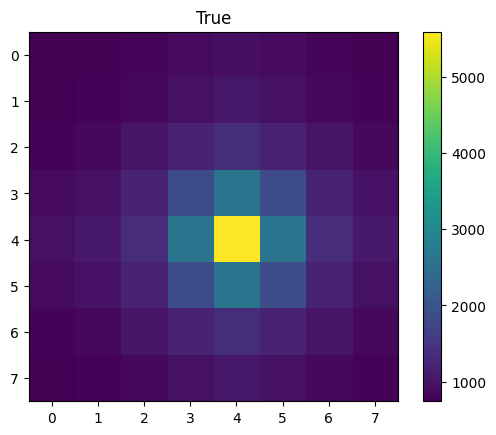

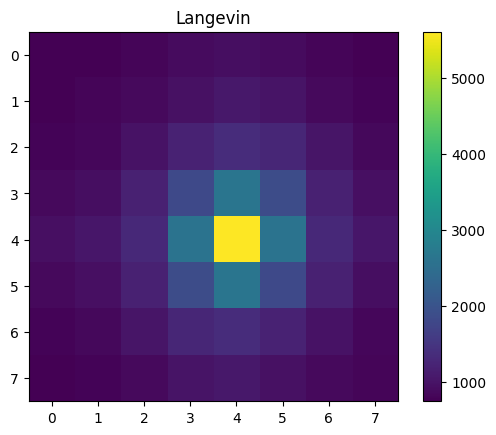

In [35]:
#Compare Synthesis and originals
Show_langevin(phi_s,x_reco,log=True)

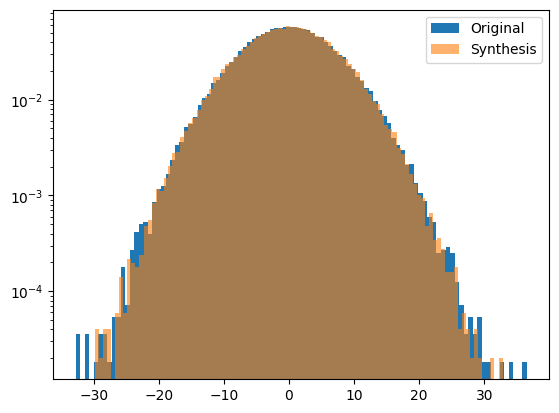

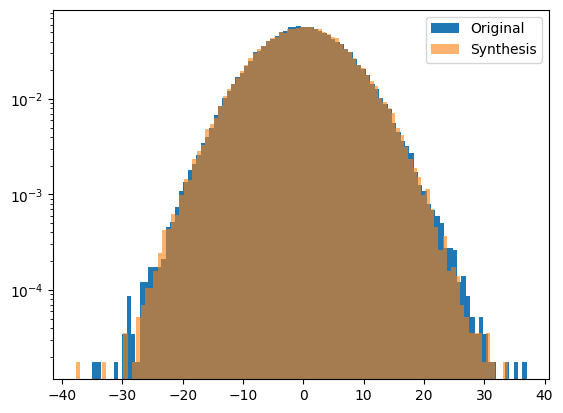

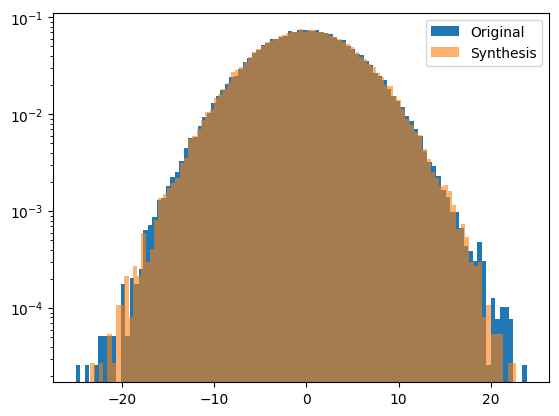

In [36]:
x_high_reco = ansatz.decompose(x_reco.cuda())[1]
x_high = ansatz.decompose(phi_s)[1][:len(x_reco)]
compare_hist(x_high_reco[:,0],x_high[:,0],bins=100)
compare_hist(x_high_reco[:,1],x_high[:,1],bins=100)
compare_hist(x_high_reco[:,2],x_high[:,2],bins=100)

# L = 16

In [37]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [38]:
#Define Scale, maps of size 2^{J-j}*2^{J-j} = L*L
L=16
depth = J-int(np.log2(L))
print('depth = '+str(depth))
#Load Real data x_j, for comparison only
phi_s = load_data(W,Data,depth,J,show_hist=False)

depth = 3


In [39]:
#Load The model we will sample from
ansatz = load_ansatz(L,KEY,dir_mod)

In [40]:
#We generate \bar x_{j+1} conditionaly to previously sampled x_{j+1}
x_reco = load(L//2,KEY,W,dir_synth)

torch.Size([5000, 8, 8])
torch.Size([5000, 16, 16])


In [41]:
window_min,window_max = ansatz.ansatze[0].centers[0],ansatz.ansatze[0].centers[-1]
n_repeat = 10
n_batch = len(x_reco)//n_repeat  # was conditionned by phi_s?!
n_steps = 200
step_size = 5e-1
x_reco = my_LANGEVINMALA(ansatz,
             x_reco,
             window_min,
             window_max,
             n_steps,
             step_size,
             n_batch,
             n_repeat,
            n_print_freq=n_steps//10)

repeat: 1/10
Acceptance_rate =0.778
Acceptance_rate =0.948
Acceptance_rate =0.954
Acceptance_rate =0.954
Acceptance_rate =0.962
Acceptance_rate =0.938
Acceptance_rate =0.944
Acceptance_rate =0.938
Acceptance_rate =0.948
Acceptance_rate =0.968
repeat: 2/10
Acceptance_rate =0.782
Acceptance_rate =0.942
Acceptance_rate =0.964
Acceptance_rate =0.96
Acceptance_rate =0.946
Acceptance_rate =0.954
Acceptance_rate =0.972
Acceptance_rate =0.958
Acceptance_rate =0.966
Acceptance_rate =0.95
repeat: 3/10
Acceptance_rate =0.806
Acceptance_rate =0.9339999999999999
Acceptance_rate =0.95
Acceptance_rate =0.94
Acceptance_rate =0.94
Acceptance_rate =0.944
Acceptance_rate =0.944
Acceptance_rate =0.97
Acceptance_rate =0.968
Acceptance_rate =0.946
repeat: 4/10
Acceptance_rate =0.804
Acceptance_rate =0.9339999999999999
Acceptance_rate =0.96
Acceptance_rate =0.96
Acceptance_rate =0.956
Acceptance_rate =0.966
Acceptance_rate =0.946
Acceptance_rate =0.9359999999999999
Acceptance_rate =0.958
Acceptance_rate =0.9

In [42]:
phi_s.shape, x_reco.shape

(torch.Size([5000, 16, 16]), torch.Size([5000, 16, 16]))

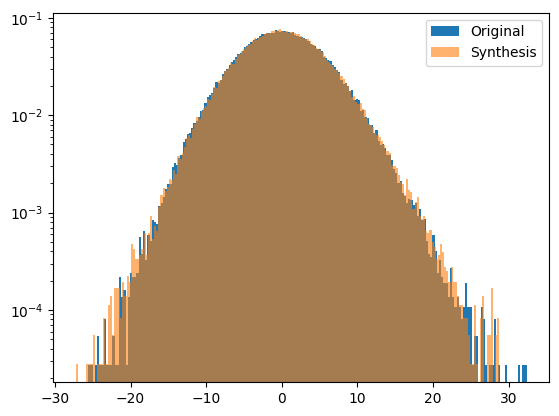

In [43]:
compare_hist(x_reco[::10],phi_s[::10],)

In [44]:
save(x_reco,L,KEY,dir_synth)

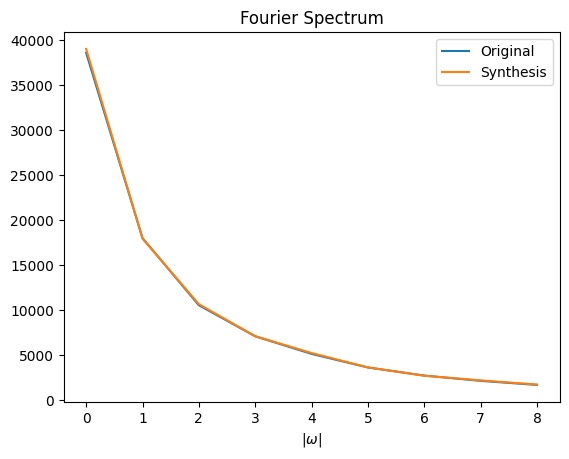

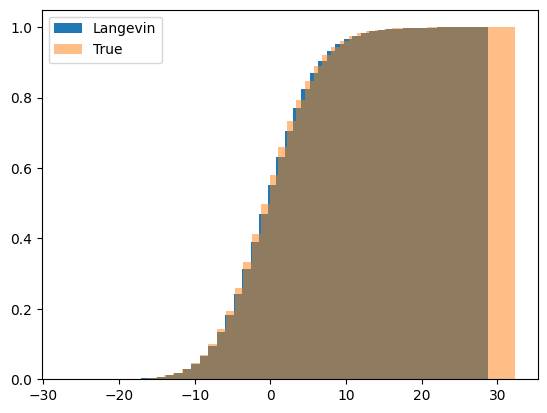

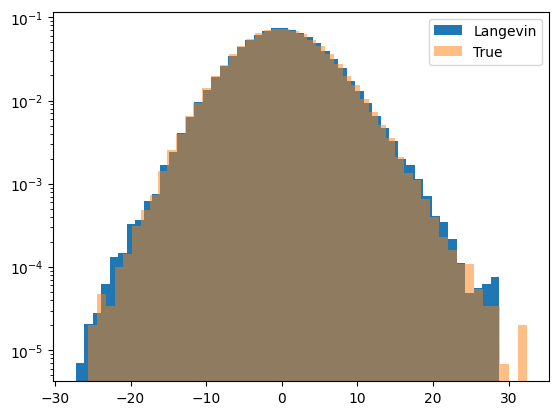

mean_true = tensor(0.0433)
std_true = tensor(5.6908)
mean_langevin = tensor(0.1353)
std_langevin = tensor(5.7050)


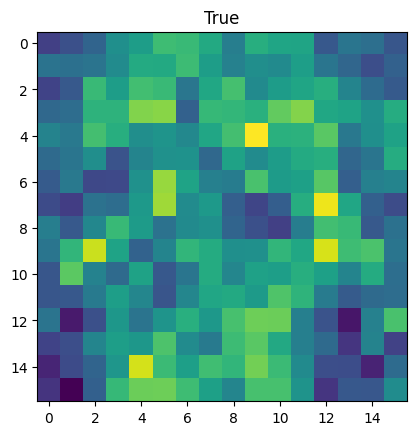

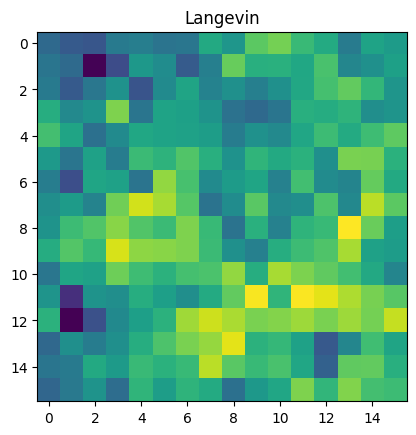

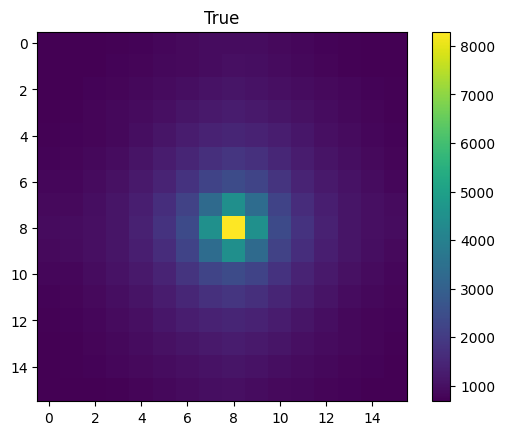

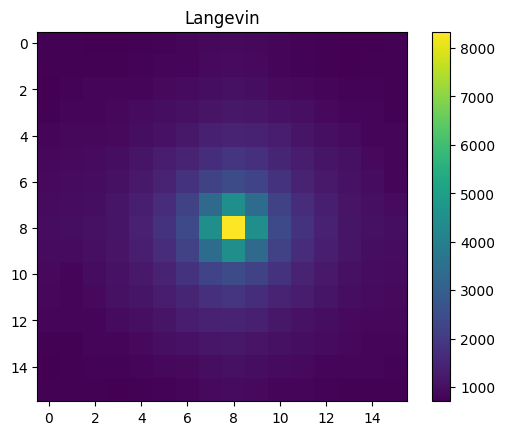

In [47]:
#Compare Synthesis and originals
Show_langevin(phi_s[::10],x_reco[::10],log=True)

# L = 32

In [48]:
import gc
gc.collect()
torch.cuda.empty_cache()


In [67]:
#Define Scale, maps of size 2^{J-j}*2^{J-j} = L*L
L=32
depth = J-int(np.log2(L))
print('depth = '+str(depth))
#Load Real data x_j, for comparison only
phi_s = load_data(W,Data,depth,J,show_hist=False)

depth = 2


In [69]:
#We generate \bar x_{j+1} conditionaly to previously sampled x_{j+1}
x_reco = load(L//2,KEY,W,dir_synth)

#Load The model we will sample from
ansatz = load_ansatz(L,KEY,dir_mod)

# JEC 20/6/23 n_batch x n_repeat = len(x_reco)  
window_min,window_max = ansatz.ansatze[0].centers[0],ansatz.ansatze[0].centers[-1]
n_repeat = 10
n_batch = (len(x_reco)//10)//n_repeat # was 500 JEC 20/6/23    2h with whole dataset
n_steps =  300   #
step_size = 2.7e-1
x_reco = my_LANGEVINMALA(ansatz,
             x_reco,
             window_min,
             window_max,
             n_steps,
             step_size,
             n_batch,
             n_repeat,
            n_print_freq=n_steps//10)

repeat: 1/10
Acceptance_rate =0.020000000000000018
Acceptance_rate =0.040000000000000036
Acceptance_rate =0.28
Acceptance_rate =0.4
Acceptance_rate =0.54
Acceptance_rate =0.6799999999999999
Acceptance_rate =0.7
Acceptance_rate =0.78
Acceptance_rate =0.74
Acceptance_rate =0.78
repeat: 2/10
Acceptance_rate =0.0
Acceptance_rate =0.14
Acceptance_rate =0.28
Acceptance_rate =0.5800000000000001
Acceptance_rate =0.6
Acceptance_rate =0.6599999999999999
Acceptance_rate =0.6799999999999999
Acceptance_rate =0.7
Acceptance_rate =0.7
Acceptance_rate =0.64
repeat: 3/10
Acceptance_rate =0.0
Acceptance_rate =0.020000000000000018
Acceptance_rate =0.21999999999999997
Acceptance_rate =0.56
Acceptance_rate =0.62
Acceptance_rate =0.8
Acceptance_rate =0.8200000000000001
Acceptance_rate =0.78
Acceptance_rate =0.78
Acceptance_rate =0.62
repeat: 4/10
Acceptance_rate =0.040000000000000036
Acceptance_rate =0.14
Acceptance_rate =0.36
Acceptance_rate =0.52
Acceptance_rate =0.6
Acceptance_rate =0.76
Acceptance_rate 

In [70]:
phi_s.shape, x_reco.shape

(torch.Size([5000, 32, 32]), torch.Size([500, 32, 32]))

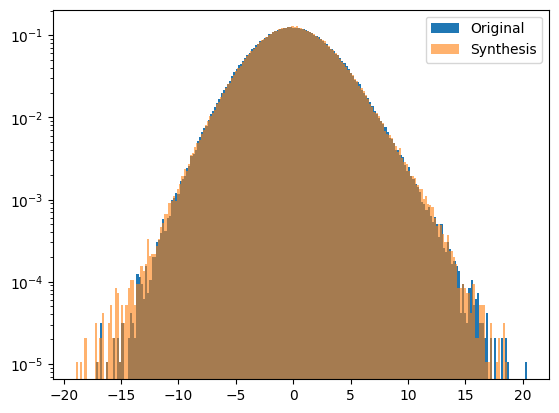

In [71]:
compare_hist(x_reco,phi_s[::10])

In [72]:
save(x_reco,L,KEY,dir_synth)

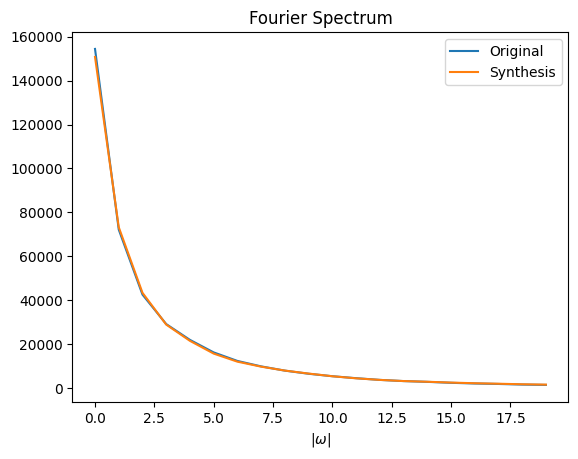

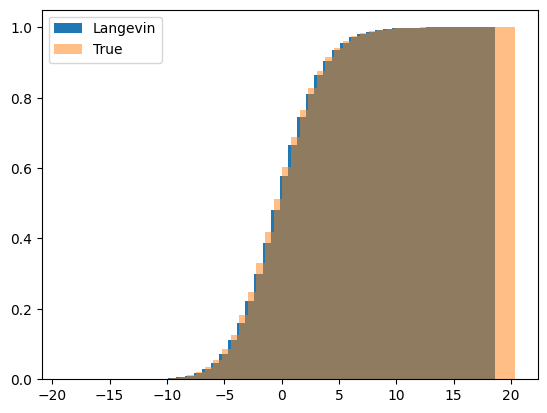

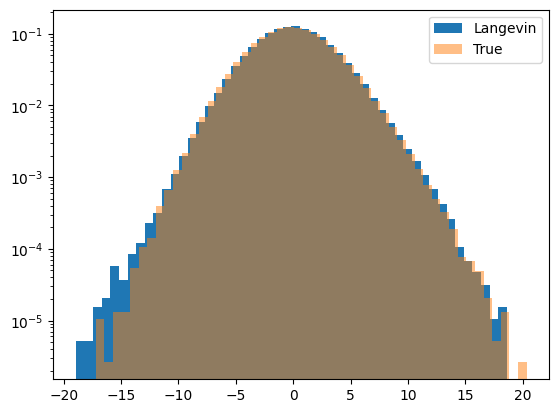

mean_true = tensor(0.0216)
std_true = tensor(3.3452)
mean_langevin = tensor(0.0423)
std_langevin = tensor(3.3419)


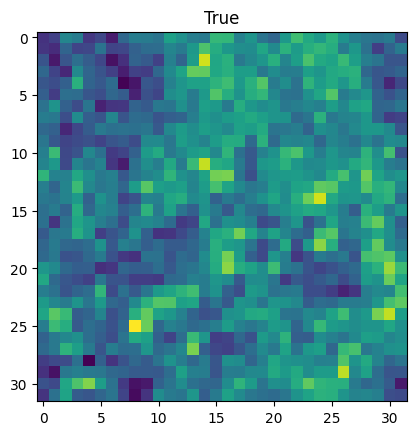

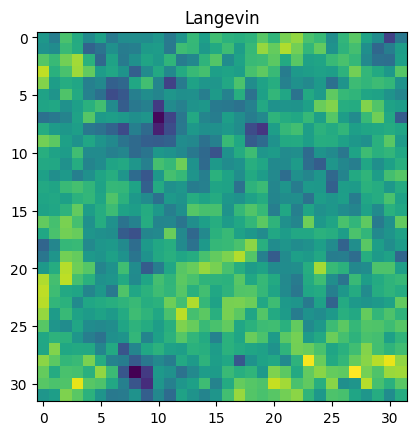

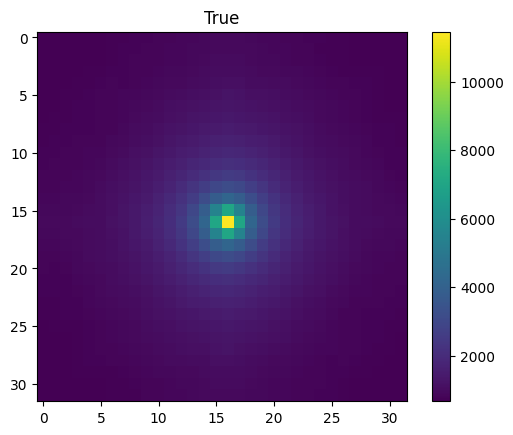

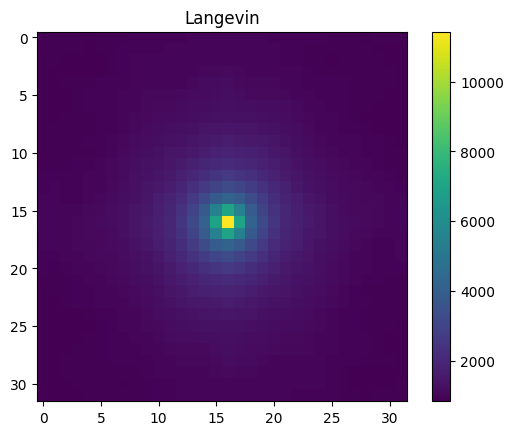

In [73]:
#Compare Synthesis and originals
Show_langevin(phi_s[::10],x_reco,log=True)

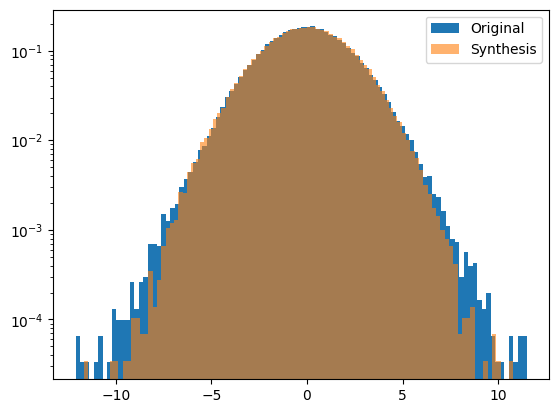

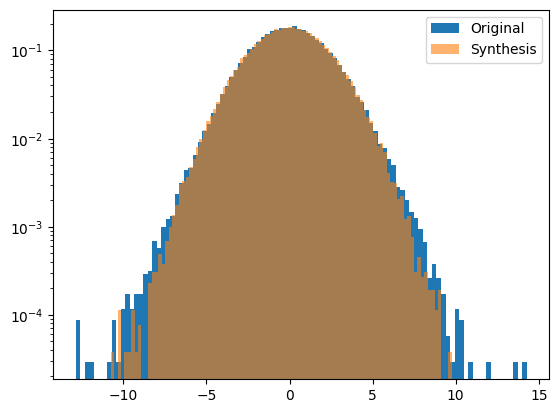

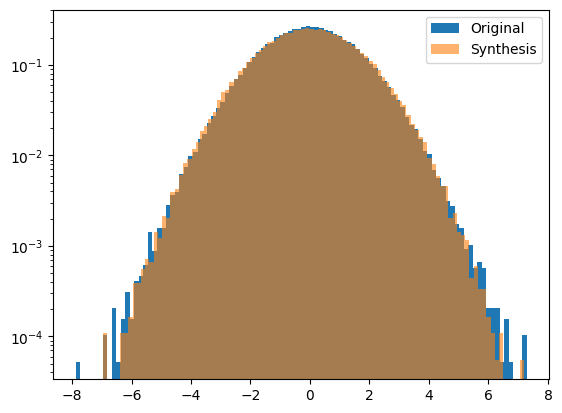

In [74]:
x_high_reco = ansatz.decompose(x_reco.cuda())[1]
x_high = ansatz.decompose(phi_s)[1][:len(x_reco)]
compare_hist(x_high_reco[:,0],x_high[:,0],bins=100)
compare_hist(x_high_reco[:,1],x_high[:,1],bins=100)
compare_hist(x_high_reco[:,2],x_high[:,2],bins=100)

# L = 64

In [86]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [87]:
#Define Scale, maps of size 2^{J-j}*2^{J-j} = L*L
L=64
depth = J-int(np.log2(L))
print('depth = '+str(depth))
#Load Real data x_j, for comparison only
phi_s = load_data(W,Data,depth,J,show_hist=False)

depth = 1


In [88]:
#We generate \bar x_{j+1} conditionaly to previously sampled x_{j+1}
x_reco = load(L//2,KEY,W,dir_synth)

#Load The model we will sample from
ansatz = load_ansatz(L,KEY,dir_mod)


window_min,window_max = ansatz.ansatze[0].centers[0],ansatz.ansatze[0].centers[-1]
n_batch = 20 # was 200 JEC 20/6/23
n_repeat = len(x_reco)//n_batch  # was 1 JEC 20/6/23

n_steps = 250
step_size = 2.0e-2
x_reco = my_LANGEVINMALA(ansatz,
             x_reco,
             window_min,
             window_max,
             n_steps,
             step_size,
             n_batch,
             n_repeat,
            n_print_freq=n_steps//10)

torch.Size([500, 32, 32])
torch.Size([500, 64, 64])
repeat: 1/25
Acceptance_rate =0.050000000000000044
Acceptance_rate =0.15000000000000002
Acceptance_rate =0.25
Acceptance_rate =0.55
Acceptance_rate =0.8
Acceptance_rate =0.9
Acceptance_rate =0.95
Acceptance_rate =0.75
Acceptance_rate =0.95
Acceptance_rate =0.85
repeat: 2/25
Acceptance_rate =0.050000000000000044
Acceptance_rate =0.15000000000000002
Acceptance_rate =0.4
Acceptance_rate =0.6
Acceptance_rate =0.65
Acceptance_rate =0.75
Acceptance_rate =0.9
Acceptance_rate =0.75
Acceptance_rate =0.9
Acceptance_rate =0.85
repeat: 3/25
Acceptance_rate =0.09999999999999998
Acceptance_rate =0.09999999999999998
Acceptance_rate =0.44999999999999996
Acceptance_rate =0.44999999999999996
Acceptance_rate =0.75
Acceptance_rate =0.8
Acceptance_rate =0.95
Acceptance_rate =0.85
Acceptance_rate =0.8
Acceptance_rate =0.85
repeat: 4/25
Acceptance_rate =0.050000000000000044
Acceptance_rate =0.15000000000000002
Acceptance_rate =0.4
Acceptance_rate =0.5
Accep

In [89]:
x_reco.shape, phi_s.shape

(torch.Size([500, 64, 64]), torch.Size([5000, 64, 64]))

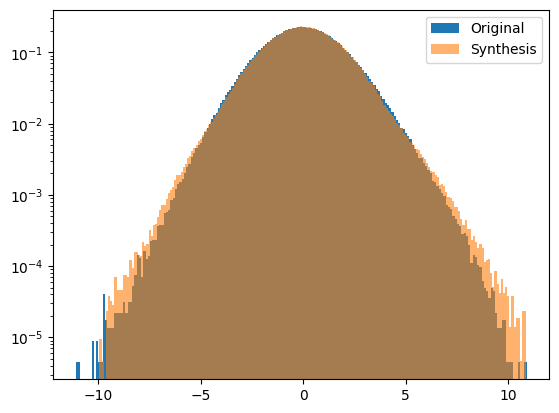

In [90]:
compare_hist(x_reco,phi_s[::10])

In [91]:
save(x_reco,L,KEY,dir_synth)

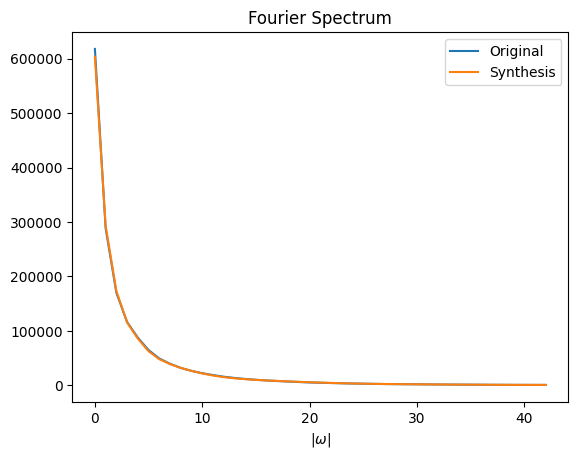

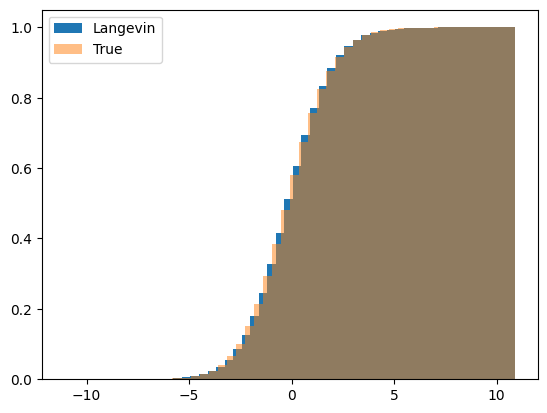

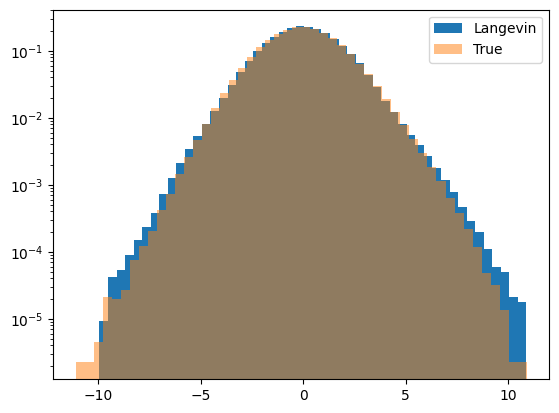

mean_true = tensor(0.0108)
std_true = tensor(1.8543)
mean_langevin = tensor(0.0211)
std_langevin = tensor(1.8513)


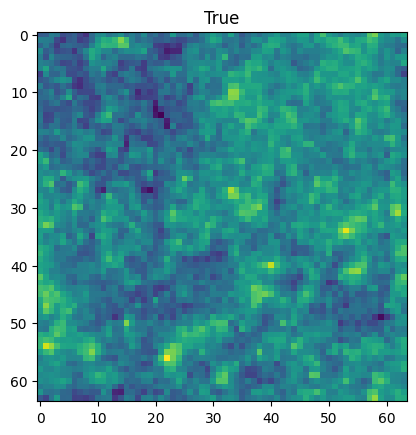

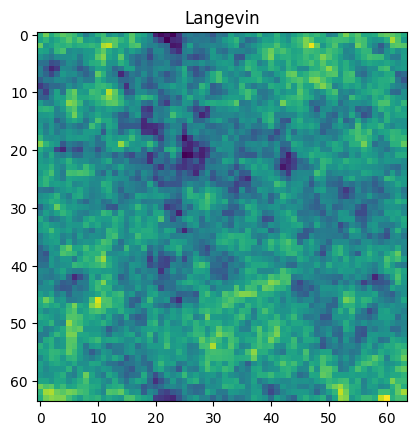

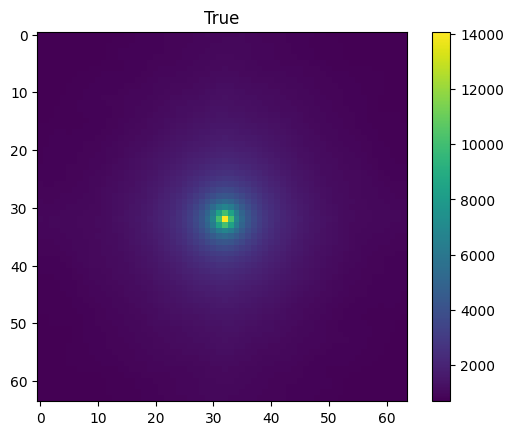

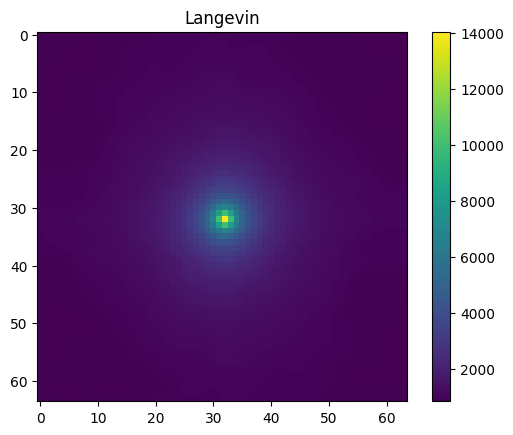

In [92]:
#Compare Synthesis and originals
Show_langevin(phi_s[::10],x_reco,log=True)

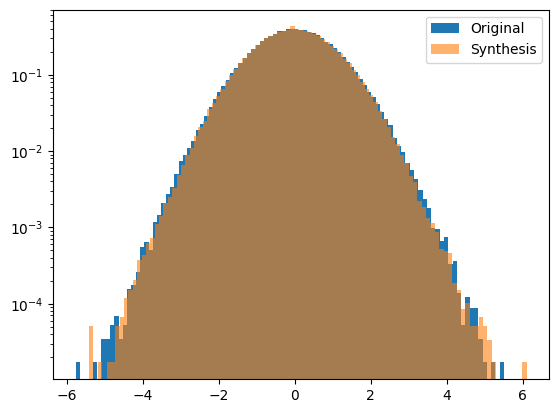

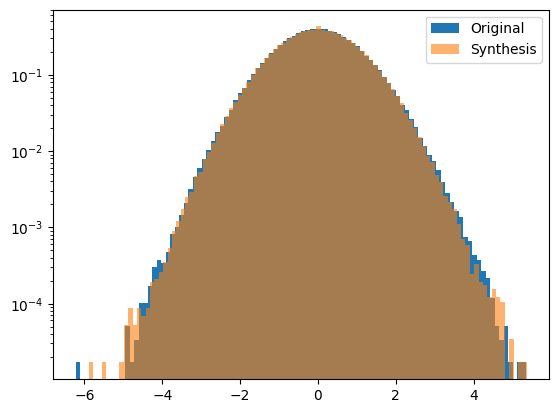

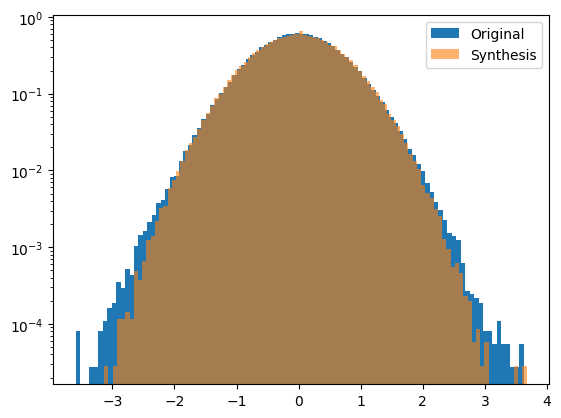

In [93]:
x_high_reco = ansatz.decompose(x_reco.cuda())[1]
x_high = ansatz.decompose(phi_s)[1][:len(x_reco)]
compare_hist(x_high_reco[:,0],x_high[:,0],bins=100)
compare_hist(x_high_reco[:,1],x_high[:,1],bins=100)
compare_hist(x_high_reco[:,2],x_high[:,2],bins=100)

# L = 128

In [94]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [95]:
#Define Scale, maps of size 2^{J-j}*2^{J-j} = L*L
L=128
depth = J-int(np.log2(L))
print('depth = '+str(depth))
#Load Real data x_j, for comparison only
phi_s = load_data(W,Data,depth,J,show_hist=False)

depth = 0


In [96]:
#We generate \bar x_{j+1} conditionaly to previously sampled x_{j+1}
x_reco = load(L//2,KEY,W,dir_synth)

#Load The model we will sample from
ansatz = load_ansatz(L,KEY,dir_mod)

window_min,window_max = ansatz.ansatze[0].centers[0],ansatz.ansatze[0].centers[-1]
n_batch =  10 #JEC 20/6/23

#n_batch = 100 # was 200 JEC 20/6/23
n_repeat = len(x_reco)//n_batch  # was 1 JEC 20/6/23

n_steps = 500
step_size = 7e-4 # xwas 2e-3
x_reco = my_LANGEVINMALA(ansatz,
             x_reco,
             window_min,
             window_max,
             n_steps,
             step_size,
             n_batch,
             n_repeat,
            n_print_freq=n_steps//10)

torch.Size([500, 64, 64])
torch.Size([500, 128, 128])
repeat: 1/50
Acceptance_rate =0.8
Acceptance_rate =0.9
Acceptance_rate =0.7
Acceptance_rate =0.8
Acceptance_rate =0.7
Acceptance_rate =0.4
Acceptance_rate =0.8
Acceptance_rate =0.8
Acceptance_rate =0.6
Acceptance_rate =0.9
repeat: 2/50
Acceptance_rate =0.9
Acceptance_rate =0.9
Acceptance_rate =1.0
Acceptance_rate =0.7
Acceptance_rate =0.7
Acceptance_rate =1.0
Acceptance_rate =0.8
Acceptance_rate =0.9
Acceptance_rate =1.0
Acceptance_rate =0.9
repeat: 3/50
Acceptance_rate =0.7
Acceptance_rate =0.7
Acceptance_rate =0.8
Acceptance_rate =0.9
Acceptance_rate =0.9
Acceptance_rate =0.6
Acceptance_rate =0.9
Acceptance_rate =0.7
Acceptance_rate =1.0
Acceptance_rate =0.7
repeat: 4/50
Acceptance_rate =0.9
Acceptance_rate =0.9
Acceptance_rate =0.8
Acceptance_rate =0.6
Acceptance_rate =0.9
Acceptance_rate =0.9
Acceptance_rate =0.7
Acceptance_rate =0.8
Acceptance_rate =0.9
Acceptance_rate =0.8
repeat: 5/50
Acceptance_rate =0.7
Acceptance_rate =0.7

In [97]:
save(x_reco,L,KEY,dir_synth)

# Final

In [98]:
L=128
depth = J-int(np.log2(L))
print('depth = '+str(depth))
#Load Real data x_j, for comparison only
phi_s = load_data(W,Data,depth,J,show_hist=False)

depth = 0


In [99]:
x_reco = torch.load(dir_synth+KEY+str(L)+'_synth.pt').to(device)

In [100]:
x_reco.shape, phi_s.shape

(torch.Size([500, 128, 128]), torch.Size([5000, 128, 128]))

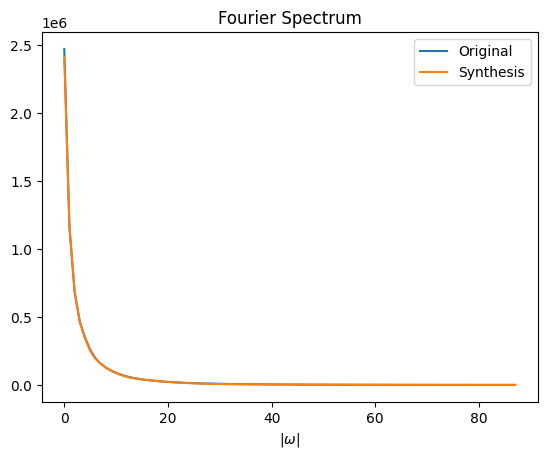

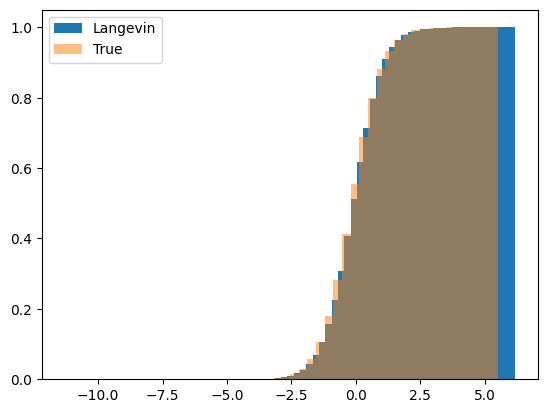

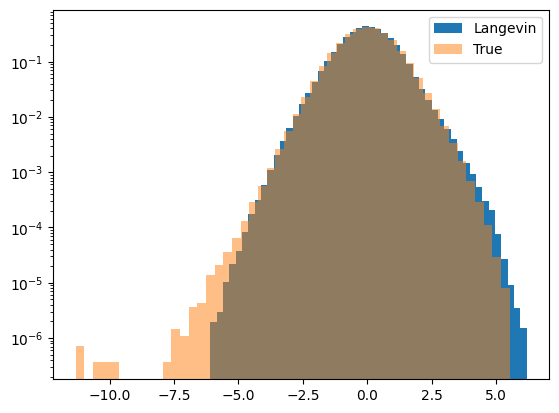

mean_true = tensor(0.0054)
std_true = tensor(0.9991)
mean_langevin = tensor(0.0106)
std_langevin = tensor(0.9845)


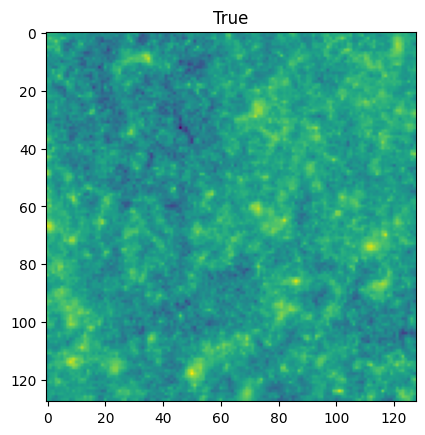

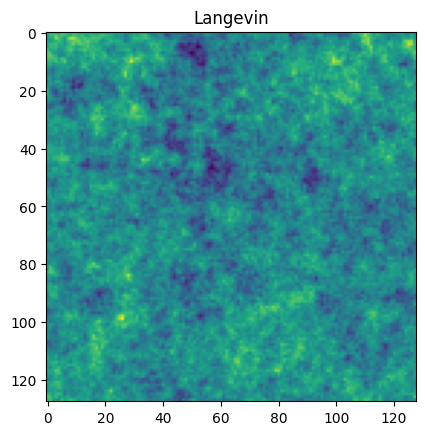

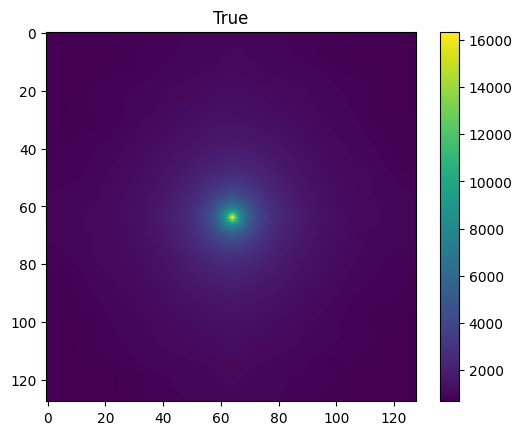

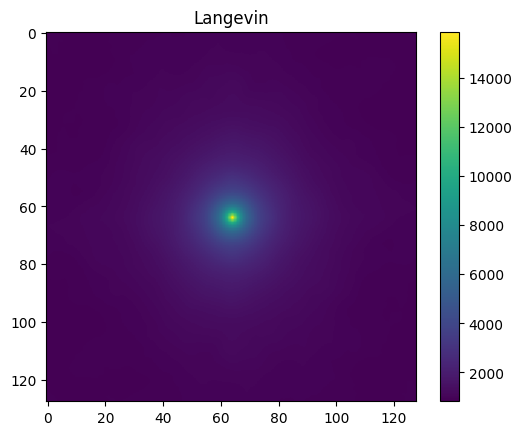

In [101]:
#Compare Synthesis and originals
Show_langevin(phi_s[::10],x_reco,log=True)

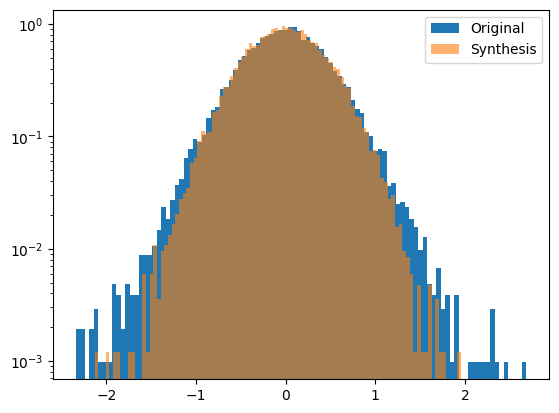

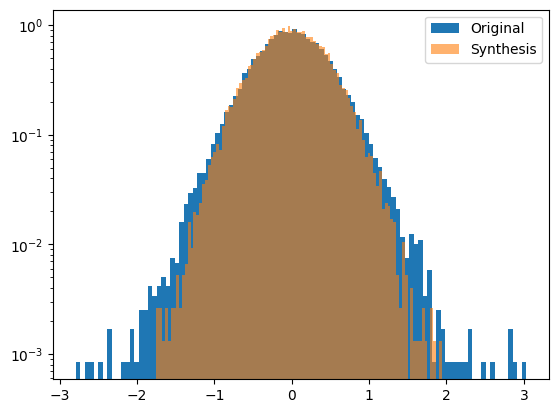

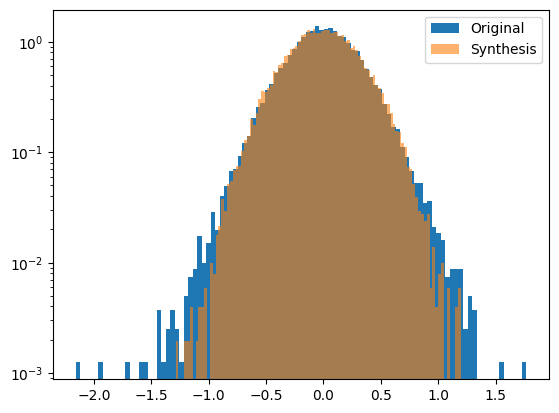

In [102]:
#Load The model we will sample from
ansatz = load_ansatz(L,KEY,dir_mod)
x_high_reco = ansatz.decompose(x_reco[::100].cuda())[1]
x_high = ansatz.decompose(phi_s[::100])[1][:len(x_reco[::100])]
compare_hist(x_high_reco[:,0],x_high[:,0],bins=100)
compare_hist(x_high_reco[:,1],x_high[:,1],bins=100)
compare_hist(x_high_reco[:,2],x_high[:,2],bins=100)

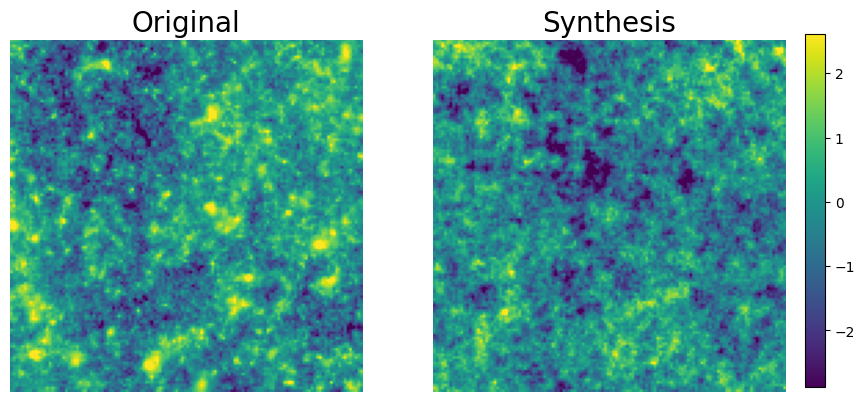

In [104]:
#Comparing samples of original and synthetised data
fig, (ax1,ax2) = plt.subplots(figsize=(10,7),nrows=1, ncols=2)
vmin = torch.quantile(phi_s[0], 0.005).cpu()
vmax = torch.quantile(phi_s[0], 0.995).cpu()


im = ax1.imshow(phi_s[0].cpu(),vmin=vmin,vmax=vmax) ; ax1.set_title('Original',fontsize=20)
ax1.axis('off')

ax2.imshow(x_reco[0].cpu(),vmin=vmin,vmax=vmax) ; ax2.set_title('Synthesis',fontsize=20)
ax2.axis('off')
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.505])
fig.colorbar(im, cax=cbar_ax)


plt.show()

In [106]:
x_reco.shape

torch.Size([500, 128, 128])

In [107]:
maps = x_reco.cpu().numpy()

In [108]:
np.save(dir_synth+'wcrg_128_500_trans.npy',maps)